# Wavelet transform

_Cho, HJ., Park, TH. Wavelet transform based image template matching for automatic component inspection. Int J Adv Manuf Technol 50, 1033–1039 (2010). https://doi.org/10.1007/s00170-010-2567-9_


# Setup


In [3]:
import cv2 as cv
import numpy as np
from skimage.io import imshow

from support.utils import cut, align

## Load image with extra component

For testing perposes extra component was artificially added to PCB

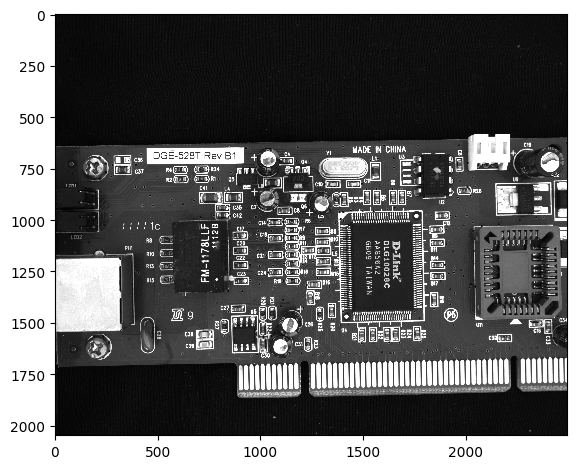

In [4]:
im_ext = cv.cvtColor(  # Image with extra component (left top corner)
    cv.imread("support/examples/21_netcard_um_16mm_f8_4320_extra_component.bmp"),
    cv.COLOR_RGB2GRAY,
)
im_ext = im_ext[:, 100:]  # Remove part that is not a subject for inspection
imshow(im_ext)

## Load image with missing component

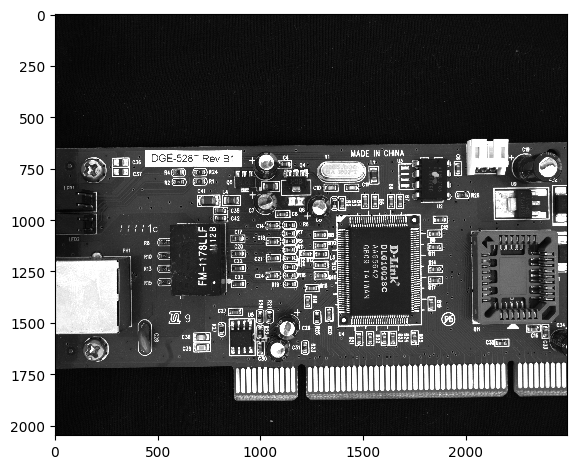

In [5]:
im = cv.cvtColor(
    cv.imread(
        "support/examples/21_netcard_um_16mm_f8_4320_extra_component_missing.bmp"
    ),
    cv.COLOR_RGB2GRAY,
)
im = im[:, 100:]  # Remove part that is not a subject for inspection
imshow(im)

# Remove background


## No extra component


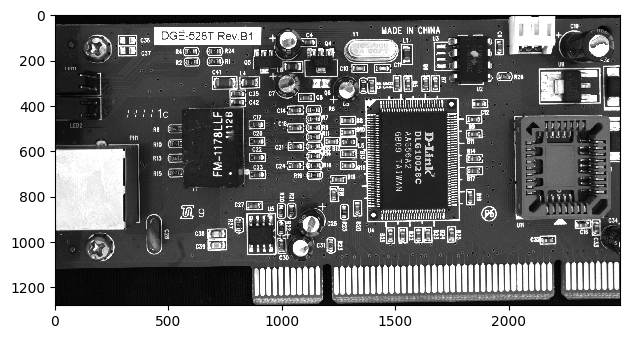

In [8]:
im1 = im

# Blur to vanish texture defects
im1 = cv.medianBlur(im1, 61)

# Arbitrary selected global threshold to separate background
val, im1 = cv.threshold(im1, 30, 255, cv.THRESH_BINARY)
# imshow(im1, cmap="gray")

analysis = cv.connectedComponentsWithStats(im1, cv.CV_32S)
(_, _, values, _) = analysis

# Select the biggest connected component (PCB desk)
mx, mxi = 0, 0
for i, value in enumerate(values):
    area = value[cv.CC_STAT_AREA]
    if area >= mx:
        mxi = i

value = values[mxi]
im2 = cut(im, value)

imshow(im2)

## Extra component

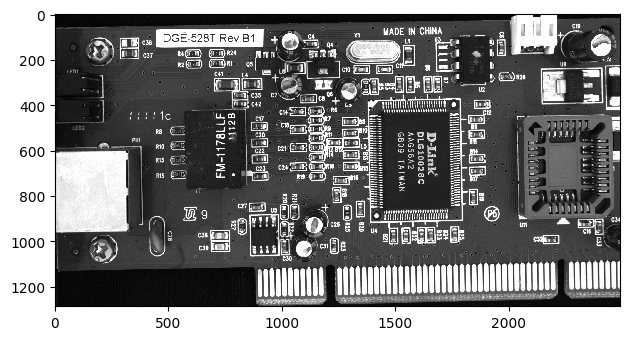

In [7]:
im1_ext = im_ext

# Blur to vanish texture defects
im1_ext = cv.medianBlur(im1_ext, 61)

# Arbitrary selected global threshold to separate background
val, im1_ext = cv.threshold(im1_ext, 30, 255, cv.THRESH_BINARY)
# imshow(im1_ext, cmap="gray")

analysis = cv.connectedComponentsWithStats(im1_ext, cv.CV_32S)
(_, _, values, _) = analysis

# Select the biggest connected component (PCB desk)
mx, mxi = 0, 0
for i, value in enumerate(values):
    area = value[cv.CC_STAT_AREA]
    if area >= mx:
        mxi = i

value = values[mxi]
im2_ext = cut(im_ext, value)

imshow(im2_ext)

## Aling images


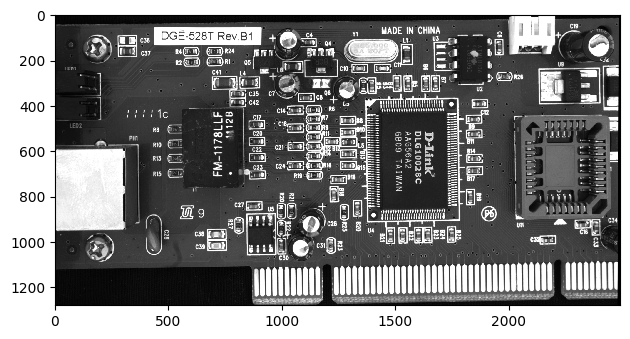

In [148]:
im2_ext = align(im2_ext, im2)
imshow(im2_ext)

# DWT Implementation

Primitive custom DWT implementation. Eq. X reference equesions in source paper.


In [107]:
def iter_average_h(im: np.ndarray):
    # Eq. 3
    r, c = im.shape[0], im.shape[1]

    res = np.zeros((r, int(np.floor(c / 2))))
    for i in range(int(np.floor(c / 2))):
        res[:, i] = (im[:, 2 * i - 1] + im[:, 2 * i]) / 2

    return res


def iter_difference_h(im: np.ndarray):
    # Eq. 4. It seems that there is an error in indexes (I assume that logic is the same as in eq. 6-9).
    r, c = im.shape[0], im.shape[1]

    res = np.zeros((r, int(np.floor(c / 2))))
    for i in range(int(np.floor(c / 2))):
        res[:, i] = (im[:, 2 * i] - im[:, 2 * i - 1]) / 2

    return res


def iter_average_v(im: np.ndarray):
    # Eq. 6, 7
    r, c = im.shape[0], im.shape[1]

    res = np.zeros((int(np.floor(r / 2)), c))
    for i in range(int(np.floor(r / 2))):
        res[i, :] = (im[2 * i - 1, :] + im[2 * i, :]) / 2

    return res


def iter_difference_v(im: np.ndarray):
    # Eq. 8, 9
    r, c = im.shape[0], im.shape[1]

    res = np.zeros((int(np.floor(r / 2)), c))
    for i in range(int(np.floor(r / 2))):
        res[i, :] = (im[2 * i, :] - im[2 * i - 1, :]) / 2

    return res


def dwt(im: np.ndarray, n=1):
    for i in range(n):
        s = iter_average_h(im)

        d = iter_difference_h(im)

        ul = iter_average_v(s)
        ur = iter_average_v(d)
        ll = iter_difference_v(s)
        lr = iter_difference_v(d)

        im = ul

    return ul, ur, ll, lr


def show_dwt(ul: np.ndarray, ur: np.ndarray, ll: np.ndarray, lr: np.ndarray):
    imshow(
        np.row_stack([np.column_stack([ul, ur]), np.column_stack([ll, lr])]),
        cmap="grey",
    )

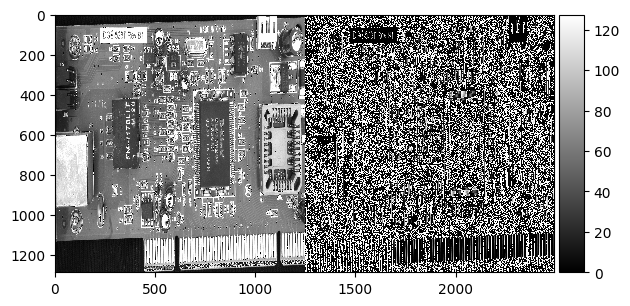

In [91]:
imshow(np.column_stack(
    [iter_average_h(im2), iter_difference_h(im2)]), cmap="grey")

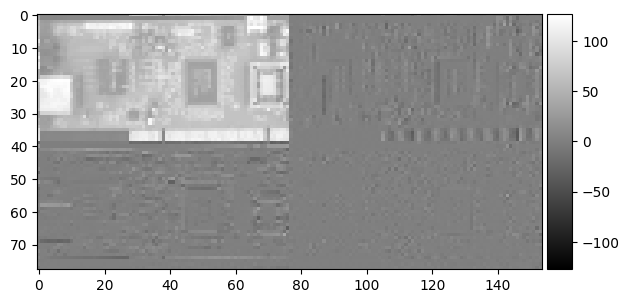

In [166]:
# 5 is arbitary selected number, no comments on this were in the paper
ul, ur, ll, lr = dwt(im2, n=5)
show_dwt(ul, ur, ll, lr)

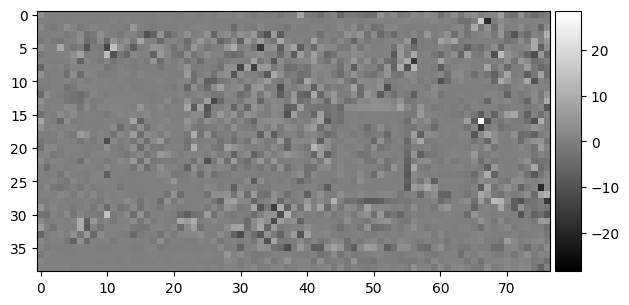

In [167]:
imshow(lr, cmap="grey")
# cv.imwrite("test.bmp", lr)

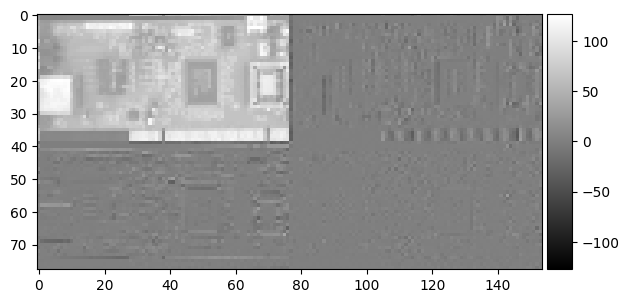

In [168]:
ul_ext, ur_ext, ll_ext, lr_ext = dwt(im2_ext, n=5)
show_dwt(ul_ext, ur_ext, ll_ext, lr_ext)

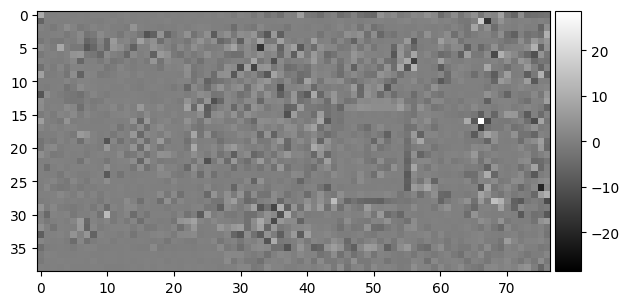

In [169]:
imshow(lr_ext, cmap="grey")
# cv.imwrite("test_ext.bmp", lr_ext)

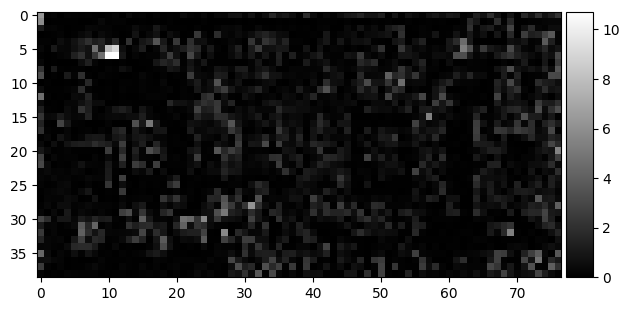

In [170]:
diff = np.abs(lr_ext - lr)
imshow(diff, cmap="grey")
# cv.imwrite("test_diff.bmp", diff)